In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
_df_data = pd.read_hdf("data/fitinputs_v2.h5", "Data")
_df_mc = pd.read_hdf("data/fitinputs_v2.h5", "MC")
_df_mc_smooth = pd.read_hdf("data/fitinputs_v2.h5", "MCSmoothv2")
_df_mc_p4 = pd.read_hdf("data/fitinputs_v2.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("data/fitinputs_v2.h5", "MCFlat")

_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [4]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    selection = (_df_mc.index.get_level_values("variation")=="") & (_df_mc.index.get_level_values("region")==region)
    tdf = _df_mc.loc[selection,:]
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Up")) & (_df_mc.index.get_level_values("region")==region)
    tdf_up = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
    )
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Down")) & (_df_mc.index.get_level_values("region")==region)
    tdf_do = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
    )
    _df_mc = pd.concat([tdf, tdf_up, tdf_do, _df_mc.loc[_df_mc.index.get_level_values("region")!=region,:].copy()], axis=0, sort=False)

## Remove nuisances

In [5]:
_df_mc.loc[("Monojet", "QCD"),:].index.get_level_values("variation").unique()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp', 'd3kqcdUp', 'dkmixUp',
       'eleEnergyScaleUp', 'eleIdIsoTightUp', 'eleIdIsoVetoUp', 'eleRecoUp',
       'eleTrigUp', 'jerSFUp', 'jesTotalUp', 'lhePdfWeightUp',
       'lheScaleWeightUp', 'lumiUp', 'metTrig0MuSystUp',
       'metTrigReferenceTriggerSystUp', 'metTrigMonojetSystUp',
       'muonIdLooseStatUp', 'muonIdLooseSystUp', 'muonIdTightStatUp',
       'muonIdTightSystUp', 'muonIsoLooseStatUp', 'muonIsoLooseSystUp',
       'muonIsoTightStatUp', 'muonIsoTightSystUp', 'muonPtScaleUp',
       'muonTrigUp', 'photonEnergyScaleUp', 'photonIdLooseUp',
       'photonPixelSeedVetoUp', 'pileupUp', 'prefiringUp', 'tauIdTightUp',
       'tauIdVLooseUp', 'tauPtScaleUp', 'unclustUp', 'alphasDown',
       'btagSFDown', 'd1kewDown', 'd1kqcdDown', 'd2kewwDown', 'd2kewzDown',
       'd2kqcdDown', 'd3kewwDown', 'd3kewzDown', 'd3kqcdDown', 'dkmixDown',
       'eleEnergyScaleDo

In [6]:
region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): ["lheScaleWeight", "eleTrig", "muonTrig"],
    ("Monojet", "WJetsToLNu"): ["lheScaleWeight", "eleTrig", "muonTrig"],
    ("Monojet", "QCD"): [
        "alphas", "btagSF", "d1kew", "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix", "eleEnergyScale", "eleIdIsoTight",
        "eleIdIsoVeto", "eleReco", "eleTrig", "jerSF", "jesTotal", "unclust", "lhePdfWeight", "lheScaleWeight", "lumi", "metTrig0MuSyst",
        "metTrigReferenceTriggerSyst", "metTrigMonojetSyst", "muonIdLooseStat", "muonIdLooseSyst", "muonIsoLooseStat", "muonIsoLooseSyst", "muonIdTightSyst",
        "muonIdTightStat", "muonIsoTightSyst", "muonIsoTightStat", "muonPtScale", "muonTrig", "photonEnergyScale", "photonIdLoose", "photonPixelSeedVeto",
        "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "tauPtScale",
    ],
    ("Monojet", "MinorBkgs"): ["eleTrig", "muonTrig"],
    ("SingleMuon", "WJetsToLNu"): ["lheScaleWeight", "muonTrig", "eleTrig"],
    ("SingleMuon", "QCD"): ["muonTrig", "eleTrig"],
    ("SingleMuon", "MinorBkgs"): ["muonTrig", "eleTrig"],
    ("SingleElectron", "WJetsToLNu"): ["lheScaleWeight", "muonTrig"],
    ("SingleElectron", "MinorBkgs"): ["muonTrig"],
    ("DoubleMuon", "DYJetsToLL"): ["lheScaleWeight", "muonTrig", "eleTrig"],
    ("DoubleMuon", "MinorBkgs"): ["muonTrig", "eleTrig"],
    ("DoubleElectron", "DYJetsToLL"): ["lheScaleWeight", "muonTrig"],
    ("DoubleElectron", "MinorBkgs"): ["muonTrig"],
}

drops = [
    (r, p, v+"Up")
    for (r, p), vs in region_process_variations.items()
    for v in vs
] + [
    (r, p, v+"Down")
    for (r, p), vs in region_process_variations.items()
    for v in vs
]
_df_mc = _df_mc.drop(drops, errors='ignore')

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


## Use gaussian filter smoothing

In [7]:
vjets = [
    "lhePdfWeight", "jesTotal", "jerSF", "unclust", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst",
    "muonIdTightStat", "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "btagSF",
]
minor_bkgs = [
    "lhePdfWeight", "lheScaleWeight", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat",
    "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]
qcd = [
    "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat", "muonIsoLooseSyst",
    "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]

region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): vjets,
    ("Monojet", "WJetsToLNu"): vjets,
    ("Monojet", "QCD"): qcd,
    ("Monojet", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "WJetsToLNu"): vjets,
    ("SingleMuon", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "QCD"): qcd,
    ("SingleElectron", "WJetsToLNu"): vjets,
    ("SingleElectron", "MinorBkgs"): minor_bkgs,
    ("DoubleMuon", "DYJetsToLL"): vjets,
    ("DoubleMuon", "MinorBkgs"): minor_bkgs,
    ("DoubleElectron", "DYJetsToLL"): vjets,
    ("DoubleElectron", "MinorBkgs"): minor_bkgs,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_smooth.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Use polyfit smoothing

In [8]:
vjets = [
    "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d3keww", "dkmix",
]

region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): vjets,
    ("Monojet", "WJetsToLNu"): vjets,
    ("SingleMuon", "WJetsToLNu"): vjets,
    ("SingleElectron", "WJetsToLNu"): vjets,
    ("DoubleMuon", "DYJetsToLL"): vjets,
    ("DoubleElectron", "DYJetsToLL"): vjets,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_p4.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


## Use flat systematic


In [9]:
qcd = ["jesTotal", "jerSF", "unclust", "pileup", "eleReco", "btagSF"]
minors = ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight", "btagSF"]

process_variations = {
    ("Monojet", "QCD"): qcd,
    ("Monojet", "MinorBkgs"): minors,
    ("SingleMuon", "WJetsToLNu"): ["jerSF"],
    ("SingleMuon", "QCD"): qcd,
    ("SingleMuon", "MinorBkgs"): minors,
    ("SingleElectron", "MinorBkgs"): minors,
    ("DoubleMuon", "MinorBkgs"): minors,
    ("DoubleElectron", "MinorBkgs"): minors,
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_flat.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass

## Symmetrize

In [10]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "tauIdTightUp"
tdf_do["variation"] = "tauIdTightDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:] = tdf_do

In [11]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "unclustUp"
tdf_do["variation"] = "unclustDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:] = tdf_do

In [12]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "jerSFUp"
tdf_do["variation"] = "jerSFDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:] = tdf_do

In [13]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "jesTotalUp"
tdf_do["variation"] = "jesTotalDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:] = tdf_do

In [14]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "eleTrigUp"
tdf_do["variation"] = "eleTrigDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigDown"),:] = tdf_do

## Split JES uncertainties

In [15]:
bin_min = _df_data.index.get_level_values("bin_min").unique().values
bin_max = _df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [16]:
#for idx, bval in enumerate(bin_min):
#    nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
#    var_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#    var_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#    
#    selection = nom.index.get_level_values("bin_min")==bval
#    var_up.loc[selection,:] = nom.loc[selection,:]
#    var_down.loc[selection,:] = nom.loc[selection,:]
#    
#    var_up["variation"] = "jesTotalB{}Up".format(idx)
#    var_down["variation"] = "jesTotalB{}Down".format(idx)
#    
#    order = ["region", "process", "variation", "bin_min", "bin_max"]
#    var_up = var_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#    var_down = var_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#    
#    _df_mc = pd.concat([_df_mc, var_down, var_up], axis=0, sort=True)
#    _df_mc.tail(5)

In [17]:
#nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
#var_low_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_low_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#var_high_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_high_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#
#selection = nom.index.get_level_values("bin_min")>1000.
#var_low_up.loc[selection,:] = nom.loc[selection,:]
#var_low_down.loc[selection,:] = nom.loc[selection,:]
#
#var_high_up.loc[~selection,:] = nom.loc[~selection,:]
#var_high_down.loc[~selection,:] = nom.loc[~selection,:]
#
#var_low_up["variation"] = "jesTotalLowUp"
#var_low_down["variation"] = "jesTotalLowDown"
#var_high_up["variation"] = "jesTotalHighUp"
#var_high_down["variation"] = "jesTotalHighDown"
#
#order = ["region", "process", "variation", "bin_min", "bin_max"]
#var_low_up = var_low_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_low_down = var_low_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_up = var_high_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_down = var_high_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#
#_df_mc = pd.concat([_df_mc, var_low_down, var_low_up, var_high_down, var_high_up], axis=0, sort=True)
#_df_mc.tail(5)

In [18]:
df_data = _df_data.unstack().unstack().loc[[
    ("MET", "Monojet"),
    ("MET", "SingleMuon"),
    ("MET", "DoubleMuon"),
    ("SingleElectron", "SingleElectron"),
    ("SingleElectron", "DoubleElectron"),
]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
df_data.head(5)

count     sum_w    sum_ww
region  bin_min bin_max                              
Monojet 200.0   220.0    100530.0  100530.0  100530.0
        220.0   250.0    142330.0  142330.0  142330.0
        250.0   280.0    102427.0  102427.0  102427.0
        280.0   310.0     66110.0   66110.0   66110.0
        310.0   340.0     41367.0   41367.0   41367.0

In [19]:
df_mc = _df_mc.copy(deep=True)
df_mc.head(30)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928
                                340.0   370.0    1475.857454    53.926664
                                370.0   400.0     992.210351    37.620910
                                400.0   430.0     663.230560    28.511451
                                430.0   470.0     560.985071    27.581216
                                470.0   510.0     344.081583    17.901991
                                510.0   550.0     224.266128    11.301424
                                550.0   590.0     143.025033     7.196915
                                590.0   640.0     115.355197     5.262883
                                640.0   690.0      68.455105     2.213242
                                690.0   740.0      40.639383     0.601003
                                740.0   790.0      25.331025     0.164831
                                790.0   840.0      17.234054     0.077535
                                840.0   900.0      12.872755     0.056071
                                900.0   960.0       7.699648     0.031386
                                960.0   1020.0      4.818195     0.020460
                                1020.0  1090.0      3.480534     0.013794
                                1090.0  1160.0      2.135376     0.008295
                                1160.0  1250.0      1.498013     0.005933
                                1250.0  1400.0      1.120919     0.004172
                                1400.0  1550.0      0.683578     0.002718
           MinorBkgs            200.0   220.0     183.419165   171.793242
                                220.0   250.0     317.971478   352.310804
                                250.0   280.0     221.964530   325.758244
                                280.0   310.0     215.624429   236.232757
                                310.0   340.0     168.794255   147.271603

## QCD corrections

In [20]:
df_mc.head(5)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928

In [21]:
df_qcd = pd.read_hdf("data/qcd_estimation.h5", "QCDCorrection")
print(df_mc.loc[("Monojet", "QCD", ""),:].head(5))
df_mc.loc[("Monojet", "QCD", ""), "sum_w"] = df_mc.loc[("Monojet", "QCD", "", pd.IndexSlice[:]), "sum_w"]*df_qcd["correction"]
df_mc.loc[("Monojet", "QCD", ""), "sum_ww"] = df_mc.loc[("Monojet", "QCD", "", pd.IndexSlice[:]), "sum_ww"]*df_qcd["correction"]**2
print(df_mc.loc[("Monojet", "QCD", ""),:].head(5))

                       sum_w         sum_ww
bin_min bin_max                            
200.0   220.0    1507.879983  870197.869365
220.0   250.0    1081.495254  239040.729627
250.0   280.0     178.490955    1689.528372
280.0   310.0     410.587219   96974.765275
310.0   340.0      48.495099     499.555464
                       sum_w        sum_ww
bin_min bin_max                           
200.0   220.0    1663.878681  1.059565e+06
220.0   250.0    1234.382422  3.114025e+05
250.0   280.0     211.843679  2.379929e+03
280.0   310.0     505.988166  1.472749e+05
310.0   340.0      61.969241  8.157186e+02


In [22]:
nom = df_mc.loc[("Monojet", "QCD", ""), "sum_w"].copy()
nom_ww = df_mc.loc[("Monojet", "QCD", ""), "sum_ww"].copy()

new_variations = []
new_variations_ww = []
for idx in range(df_qcd.shape[0]):
    vari_up = nom.copy()
    vari_do = nom.copy()
    vari_up.iloc[idx] = (nom*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_do.iloc[idx] = (nom*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_up = vari_up.to_frame()
    vari_do = vari_do.to_frame()
    vari_up["variation"] = "qcdSystB{}Up".format(idx)
    vari_do["variation"] = "qcdSystB{}Down".format(idx)
    vari_up = vari_up.set_index("variation", append=True)
    vari_do = vari_do.set_index("variation", append=True)
    
    vari_ww_up = nom_ww.copy()
    vari_ww_do = nom_ww.copy()
    vari_ww_up.iloc[idx] = (nom_ww*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_ww_do.iloc[idx] = (nom_ww*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_ww_up = vari_ww_up.to_frame()
    vari_ww_do = vari_ww_do.to_frame()
    vari_ww_up["variation"] = "qcdSystB{}Up".format(idx)
    vari_ww_do["variation"] = "qcdSystB{}Down".format(idx)
    vari_ww_up = vari_ww_up.set_index("variation", append=True)
    vari_ww_do = vari_ww_do.set_index("variation", append=True)
    
    new_variations.extend([vari_up, vari_do])
    new_variations_ww.extend([vari_ww_up, vari_ww_do])
    
df_out = pd.concat([pd.concat(new_variations), pd.concat(new_variations_ww)], axis=1)
df_out["region"] = "Monojet"
df_out["process"] = "QCD"
df_out = df_out.set_index(["region", "process"], append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

df_mc = pd.concat([df_mc, df_out], sort=True)
print(df_mc.head(5))

                                                       sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928


## GStar contribution

In [23]:
df_kzkg = pd.read_hdf("data/gstar_prediction.h5", "GStarPredictions").set_index("parameter").stack()
df_kzkg.index.names = ["parameter", "variation"]
value = df_kzkg.loc[(pd.IndexSlice[:],"value")]
relvals = df_kzkg.divide(value)-1.

selection = df_kzkg.index.get_level_values("variation")!="value"
df_kzkg.loc[selection] = relvals.loc[selection]

dyll = df_mc.loc[(pd.IndexSlice[:], "DYJetsToLL"), :].reset_index("process", drop=True)
levels = df_mc.index.names

zll = dyll.copy(deep=True)
zll.loc[:,"sum_w"] = zll["sum_w"]*df_kzkg.loc[("kz", "value")]
zll.loc[:,"sum_ww"] = zll["sum_ww"]*(df_kzkg.loc[("kz", "value")]**2)
zll["process"] = "ZJetsToLL"
zll = zll.set_index("process", append=True).reorder_levels(levels).sort_index()

# variations
variations = []
zll_nom = zll.loc[(pd.IndexSlice[:], "ZJetsToLL", ""), :].reset_index("variation", drop=True)

for updown in ["Up", "Down"]:
    zll_vari = zll_nom.copy(deep=True)
    zll_vari.loc[:,"sum_w"] = zll_vari["sum_w"]*(1 + df_kzkg.loc[("kz", "stat{}".format(updown))])
    zll_vari.loc[:,"sum_ww"] = zll_vari["sum_ww"]*((1 + df_kzkg.loc[("kz", "stat{}".format(updown))])**2)
    zll_vari["variation"] = "kzStat{}".format(updown)
    zll_vari = zll_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(zll_vari)
    
for updown in ["Up", "Down"]:
    zll_vari = zll_nom.copy(deep=True)
    zll_vari.loc[:,"sum_w"] = zll_vari["sum_w"]*(1 + df_kzkg.loc[("kz", "genIdReweight"+updown)])
    zll_vari.loc[:,"sum_ww"] = zll_vari["sum_ww"]*((1 + df_kzkg.loc[("kz", "genIdReweight"+updown)])**2)
    zll_vari["variation"] = "genIdReweight"+updown
    zll_vari = zll_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(zll_vari)
    
for updown in ["Up", "Down"]:
    zll_vari = zll_nom.copy(deep=True)
    zll_pdf = zll.loc[(pd.IndexSlice[:], "ZJetsToLL", "lhePdfWeight"+updown), :].reset_index("variation", drop=True)
    zll_vari.loc[:,"sum_w"] = zll_vari["sum_w"]*df_kzkg.loc[("kz", "lhePdfWeight"+updown)]
    zll_vari["variation"] = "lhePdfWeight"+updown
    zll_vari = zll_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    zll.loc[(pd.IndexSlice[:], "ZJetsToLL", "lhePdfWeight"+updown),"sum_w"] = (
        zll.loc[(pd.IndexSlice[:], "ZJetsToLL", "lhePdfWeight"+updown),"sum_w"]
        + zll_vari["sum_w"]
    )

gstar = dyll.copy(deep=True)
gstar.loc[:,"sum_w"] = gstar["sum_w"]*df_kzkg.loc[("kg", "value")]
gstar.loc[:,"sum_ww"] = gstar["sum_ww"]*(df_kzkg.loc[("kg", "value")]**2)
gstar["process"] = "GStarJetsToLL"
gstar = gstar.set_index("process", append=True).reorder_levels(levels).sort_index()

gstar_nom = gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", ""),:].reset_index("variation", drop=True)
for updown in ["Up", "Down"]:
    gstar_vari = gstar_nom.copy(deep=True)
    gstar_vari.loc[:,"sum_w"] = gstar_vari["sum_w"]*(1 + df_kzkg.loc[("kg", "stat{}".format(updown))])
    gstar_vari.loc[:,"sum_ww"] = gstar_vari["sum_ww"]*((1 + df_kzkg.loc[("kg", "stat{}".format(updown))])**2)
    gstar_vari["variation"] = "kgStat{}".format(updown)
    gstar_vari = gstar_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(gstar_vari)
    
for updown in ["Up", "Down"]:
    gstar_vari = gstar_nom.copy(deep=True)
    gstar_vari.loc[:,"sum_w"] = gstar_vari["sum_w"]*(1 + df_kzkg.loc[("kg", "genIdReweight"+updown)])
    gstar_vari.loc[:,"sum_ww"] = gstar_vari["sum_ww"]*((1 + df_kzkg.loc[("kg", "genIdReweight"+updown)])**2)
    gstar_vari["variation"] = "genIdReweight"+updown
    gstar_vari = gstar_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(gstar_vari)
    
for updown in ["Up", "Down"]:
    gstar_vari = gstar_nom.copy(deep=True)
    gstar_pdf = gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", "lhePdfWeight"+updown), :].reset_index("variation", drop=True)
    gstar_vari.loc[:,"sum_w"] = gstar_vari["sum_w"]*df_kzkg.loc[("kz", "lhePdfWeight"+updown)]
    gstar_vari["variation"] = "lhePdfWeight"+updown
    gstar_vari = gstar_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", "lhePdfWeight"+updown),"sum_w"] = (
        gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", "lhePdfWeight"+updown),"sum_w"]
        + gstar_vari["sum_w"]
    )
        
df_mc = pd.concat([df_mc, zll, gstar]+variations, axis=0, sort=True)

## Run fits

In [24]:
bin_min = df_data.index.get_level_values("bin_min").unique().values
bin_max = df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [25]:
df_mc.index.get_level_values("variation").unique()

Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp',
       ...
       'qcdSystB8Down', 'qcdSystB8Up', 'qcdSystB9Down', 'qcdSystB9Up',
       'kzStatUp', 'kzStatDown', 'genIdReweightUp', 'genIdReweightDown',
       'kgStatUp', 'kgStatDown'],
      dtype='object', name='variation', length=155)

In [26]:
df_kzkg = pd.read_hdf("data/gstar_prediction.h5", "GStarPredictions").set_index("parameter").stack()
df_kzkg.index.names = ["parameter", "variation"]
value = df_kzkg.loc[(pd.IndexSlice[:],"value")]
relvals = df_kzkg.divide(value)-1.

selection = df_kzkg.index.get_level_values("variation")!="value"
df_kzkg.loc[selection] = relvals.loc[selection]
df_kzkg

parameter  variation         
kz         value                 1.016459
           statUp                0.000825
           statDown             -0.000824
           genIdReweightUp       0.014404
           genIdReweightDown    -0.014404
           lhePdfWeightUp        0.022977
           lhePdfWeightDown     -0.022977
           lheScaleWeightUp      0.000000
           lheScaleWeightDown    0.000000
kg         value                 0.015040
           statUp                0.001487
           statDown             -0.001485
           genIdReweightUp       0.134813
           genIdReweightDown    -0.134813
           lhePdfWeightUp        0.024335
           lhePdfWeightDown     -0.024335
           lheScaleWeightUp      0.000000
           lheScaleWeightDown    0.000000
dtype: float64

In [36]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer = model.fit()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [37]:
%time minimizer.migrad(ncall=100_000)

RuntimeError: exception was raised in user function
User function arguments:
                     rZJetsToLL = +0.966828
                   rZJetsToNuNu = +0.995540
                    rWJetsToLNu = +1.066326
                         kzStat = +0.001508
                         kgStat = -0.000041
                  genIdReweight = +0.022655
                 metTrig0MuSyst = +1.574574
                 metTrig1MuSyst = +0.341020
                 metTrig2MuSyst = +0.273752
    metTrigReferenceTriggerSyst = +0.437400
                      qcdSystB0 = -0.077997
                      qcdSystB1 = -0.076014
                      qcdSystB2 = +0.351723
                      qcdSystB3 = -0.033380
                      qcdSystB4 = -0.027373
                      qcdSystB5 = +0.013346
                      qcdSystB6 = +0.017564
                      qcdSystB7 = +0.029451
                      qcdSystB8 = -0.009082
                      qcdSystB9 = +0.001718
                     qcdSystB10 = +0.005146
                     qcdSystB11 = -0.000018
                     qcdSystB12 = +0.018353
                     qcdSystB13 = +0.003244
                     qcdSystB14 = +0.000721
                     qcdSystB15 = +0.000000
                     qcdSystB16 = +0.000000
                     qcdSystB17 = -0.000571
                     qcdSystB18 = +0.000000
                     qcdSystB19 = +0.027060
                     qcdSystB20 = +0.000000
                     qcdSystB21 = +0.001174
                     qcdSystB22 = +0.000000
                     qcdSystB23 = +0.000000
                     qcdSystB24 = +0.000000
             metTrigMonojetSyst = +0.546813
          metTrigSingleMuonSyst = +0.753523
          metTrigDoubleMuonSyst = -0.543731
                muonIdLooseSyst = -0.000118
                muonIdLooseStat = -0.000104
                muonIdTightSyst = -0.232832
                muonIdTightStat = -0.273823
               muonIsoLooseSyst = -0.000005
               muonIsoLooseStat = -0.000015
               muonIsoTightSyst = +0.000378
               muonIsoTightStat = -0.030908
                  eleIdIsoTight = +0.003982
                   eleIdIsoVeto = -0.003519
                        eleReco = -0.024878
                        eleTrig = -0.047295
                  photonIdLoose = +0.000199
            photonPixelSeedVeto = -0.000221
                    tauIdVLoose = -0.380888
                     tauIdTight = +0.000000
                         btagSF = +0.001484
                       jesTotal = -0.000172
                          jerSF = -0.000804
                        unclust = -0.001630
                           lumi = +0.442667
                         pileup = +0.083775
                      prefiring = +0.067531
                         d1kqcd = -0.280166
                         d2kqcd = +0.758444
                         d3kqcd = -0.336116
                          d1kew = +0.005800
                         d2kewz = -0.105652
                         d2keww = +0.082275
                         d3kewz = -0.307326
                         d3keww = +0.107202
                          dkmix = -0.007397
                   lhePdfWeight = +0.006754
                 lheScaleWeight = -0.000006
            Monojet_mcstat_bin0 = -0.745780
            Monojet_mcstat_bin1 = +0.287245
            Monojet_mcstat_bin2 = +1.288278
            Monojet_mcstat_bin3 = +0.361777
            Monojet_mcstat_bin4 = -0.301958
            Monojet_mcstat_bin5 = -1.704126
            Monojet_mcstat_bin6 = -1.083604
            Monojet_mcstat_bin7 = +0.840369
            Monojet_mcstat_bin8 = +0.698905
            Monojet_mcstat_bin9 = -0.505412
           Monojet_mcstat_bin10 = -0.115859
           Monojet_mcstat_bin11 = -0.048979
           Monojet_mcstat_bin12 = +0.788408
           Monojet_mcstat_bin13 = +0.601603
           Monojet_mcstat_bin14 = +0.567476
           Monojet_mcstat_bin15 = -1.137796
           Monojet_mcstat_bin16 = -0.387123
           Monojet_mcstat_bin17 = +0.118039
           Monojet_mcstat_bin18 = -0.275584
           Monojet_mcstat_bin19 = -0.272963
           Monojet_mcstat_bin20 = +0.012327
           Monojet_mcstat_bin21 = -0.042598
           Monojet_mcstat_bin22 = +0.102823
           Monojet_mcstat_bin23 = +0.099645
           Monojet_mcstat_bin24 = +0.084375
         SingleMuon_mcstat_bin0 = +1.097394
         SingleMuon_mcstat_bin1 = -0.788324
         SingleMuon_mcstat_bin2 = -1.004067
         SingleMuon_mcstat_bin3 = +0.459524
         SingleMuon_mcstat_bin4 = +0.093096
         SingleMuon_mcstat_bin5 = -0.507188
         SingleMuon_mcstat_bin6 = -1.962418
         SingleMuon_mcstat_bin7 = +0.884150
         SingleMuon_mcstat_bin8 = +1.469009
         SingleMuon_mcstat_bin9 = +1.737298
        SingleMuon_mcstat_bin10 = +0.341685
        SingleMuon_mcstat_bin11 = -0.591027
        SingleMuon_mcstat_bin12 = +0.271857
        SingleMuon_mcstat_bin13 = +0.367623
        SingleMuon_mcstat_bin14 = +0.381189
        SingleMuon_mcstat_bin15 = +0.295620
        SingleMuon_mcstat_bin16 = +0.348711
        SingleMuon_mcstat_bin17 = +0.456015
        SingleMuon_mcstat_bin18 = -0.088633
        SingleMuon_mcstat_bin19 = -0.873414
        SingleMuon_mcstat_bin20 = -0.181050
        SingleMuon_mcstat_bin21 = -0.246228
        SingleMuon_mcstat_bin22 = -0.093504
        SingleMuon_mcstat_bin23 = -0.754570
        SingleMuon_mcstat_bin24 = -0.350237
     SingleElectron_mcstat_bin0 = -0.138550
     SingleElectron_mcstat_bin1 = +0.255695
     SingleElectron_mcstat_bin2 = +0.200698
     SingleElectron_mcstat_bin3 = -0.110418
     SingleElectron_mcstat_bin4 = -1.692254
     SingleElectron_mcstat_bin5 = -0.702918
     SingleElectron_mcstat_bin6 = +0.224118
     SingleElectron_mcstat_bin7 = +0.187451
     SingleElectron_mcstat_bin8 = +0.874129
     SingleElectron_mcstat_bin9 = +0.830119
    SingleElectron_mcstat_bin10 = +0.906690
    SingleElectron_mcstat_bin11 = -0.422306
    SingleElectron_mcstat_bin12 = +0.901083
    SingleElectron_mcstat_bin13 = -0.094799
    SingleElectron_mcstat_bin14 = -0.487065
    SingleElectron_mcstat_bin15 = -0.386114
    SingleElectron_mcstat_bin16 = -1.265949
    SingleElectron_mcstat_bin17 = -0.657877
    SingleElectron_mcstat_bin18 = +0.213868
    SingleElectron_mcstat_bin19 = -0.210688
    SingleElectron_mcstat_bin20 = +0.131118
    SingleElectron_mcstat_bin21 = +0.162899
    SingleElectron_mcstat_bin22 = -0.036635
    SingleElectron_mcstat_bin23 = -0.314903
    SingleElectron_mcstat_bin24 = +0.048560
         DoubleMuon_mcstat_bin0 = -0.172656
         DoubleMuon_mcstat_bin1 = +0.467070
         DoubleMuon_mcstat_bin2 = +0.077762
         DoubleMuon_mcstat_bin3 = -0.286569
         DoubleMuon_mcstat_bin4 = -0.477682
         DoubleMuon_mcstat_bin5 = -0.113312
         DoubleMuon_mcstat_bin6 = +0.007364
         DoubleMuon_mcstat_bin7 = +0.302302
         DoubleMuon_mcstat_bin8 = -0.012445
         DoubleMuon_mcstat_bin9 = +0.027467
        DoubleMuon_mcstat_bin10 = +0.069510
        DoubleMuon_mcstat_bin11 = +0.524589
        DoubleMuon_mcstat_bin12 = -0.103945
        DoubleMuon_mcstat_bin13 = +0.236646
        DoubleMuon_mcstat_bin14 = +0.128707
        DoubleMuon_mcstat_bin15 = +0.166756
        DoubleMuon_mcstat_bin16 = -0.191261
        DoubleMuon_mcstat_bin17 = -0.038043
        DoubleMuon_mcstat_bin18 = +0.054105
        DoubleMuon_mcstat_bin19 = -0.065475
        DoubleMuon_mcstat_bin20 = -0.080022
        DoubleMuon_mcstat_bin21 = -0.183900
        DoubleMuon_mcstat_bin22 = +0.017647
        DoubleMuon_mcstat_bin23 = +0.456332
        DoubleMuon_mcstat_bin24 = -0.043919
     DoubleElectron_mcstat_bin0 = +0.339623
     DoubleElectron_mcstat_bin1 = -0.040657
     DoubleElectron_mcstat_bin2 = +0.269690
     DoubleElectron_mcstat_bin3 = -0.153926
     DoubleElectron_mcstat_bin4 = -0.195913
     DoubleElectron_mcstat_bin5 = -0.174324
     DoubleElectron_mcstat_bin6 = -0.038452
     DoubleElectron_mcstat_bin7 = +0.143719
     DoubleElectron_mcstat_bin8 = +0.114820
     DoubleElectron_mcstat_bin9 = +0.197028
    DoubleElectron_mcstat_bin10 = +0.135739
    DoubleElectron_mcstat_bin11 = -0.053601
    DoubleElectron_mcstat_bin12 = -0.053661
    DoubleElectron_mcstat_bin13 = +0.105475
    DoubleElectron_mcstat_bin14 = +0.081730
    DoubleElectron_mcstat_bin15 = +0.150137
    DoubleElectron_mcstat_bin16 = +0.045972
    DoubleElectron_mcstat_bin17 = +0.329468
    DoubleElectron_mcstat_bin18 = -0.179521
    DoubleElectron_mcstat_bin19 = -0.068799
    DoubleElectron_mcstat_bin20 = -0.050332
    DoubleElectron_mcstat_bin21 = +0.146952
    DoubleElectron_mcstat_bin22 = -0.139290
    DoubleElectron_mcstat_bin23 = -0.040351
    DoubleElectron_mcstat_bin24 = +0.028427


In [44]:
results = dftools.fitting.run_profile_likelihood_nd(
    ("rZJetsToLL", "rZJetsToNuNu"),
    (np.linspace(0.8, 1.2, 51), np.linspace(0.8, 1.2, 51)),
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=dict(minimizer.values),
)

2019-10-02 01:35:30,431 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191002_013530_bx_c1_sf


KeyboardInterrupt: 

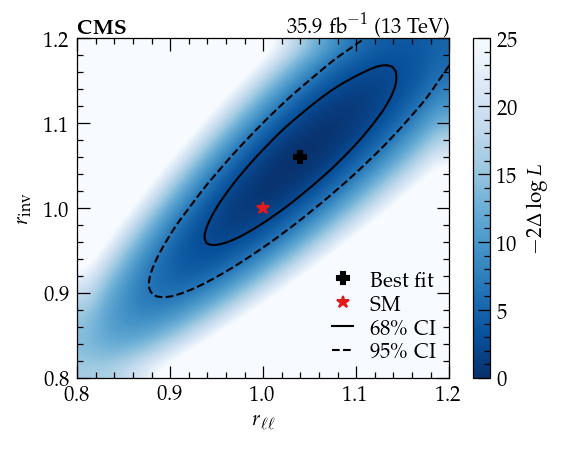

In [143]:
import matplotlib as mpl
import scipy.ndimage

fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

xbins = results["pv0"].unique()
ybins = results["pv1"].unique()

z = results.set_index(["pv0", "pv1"])["dnll"].unstack().values.T
pos = ax.imshow(
    z, origin='lower', interpolation='bicubic',
    extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    aspect='auto', cmap="Blues_r",
    vmin=0., vmax=25.,
)
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label(r'$-2\Delta\log L$')

X, Y = np.meshgrid(xbins, ybins)
ax.contour(
    scipy.ndimage.zoom(X, 4),
    scipy.ndimage.zoom(Y, 4),
    scipy.ndimage.zoom(z, 4),
    levels=[scipy.stats.chi2.ppf(0.68, df=2)],
    colors=['black'],
)
ax.contour(
    scipy.ndimage.zoom(X, 4),
    scipy.ndimage.zoom(Y, 4),
    scipy.ndimage.zoom(z, 4),
    levels=[scipy.stats.chi2.ppf(0.95, df=2)],
    colors=['black'], linestyles='dashed',
)
ax.plot(
    1, 1, '*', color='#e31a1c',
    ms=6, label="SM",
)
bf = (
    results.loc[results["dnll"]==results["dnll"].min(), "pv0"],
    results.loc[results["dnll"]==results["dnll"].min(), "pv1"],
)
ax.plot(
    *bf, 'P', color='black',
    ms=6, label="Best fit",
)
handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1] + [
    mpl.lines.Line2D([0], [0], color='black', lw=1),
    mpl.lines.Line2D([0], [0], color='black', lw=1, ls='--'),
]
labels = labels[::-1] + [r'$68\%$ CI', r'$95\%$ CI']
ax.legend(
    handles, labels,
    loc=4, labelspacing=0.1, borderpad=0.2,
    fancybox=True, edgecolor='#d9d9d9',
    framealpha=0., handlelength=1.,
)
dftools.draw.cms_label(ax, "")

ax.set_xlabel(r'$r_{\ell\ell}$')
ax.set_ylabel(r'$r_{\mathrm{inv}}$')
fig.savefig("plots/scan-2d.pdf")
pass

,p0,pbf0,pv0,p1,pbf1,pv1,dnll
265,rZJetsToLL,1.03794,1.04,rZJetsToNuNu,1.059711,1.06,0.003545
